# 0 Imports

In [94]:
import pickle
import datetime
import inflection

import numpy    as np
import pandas   as pd
import seaborn  as sns

from matplotlib import pyplot as plt

from IPython.display        import Image
from IPython.core.display   import HTML

## 0.1 Funções Suporte

In [3]:
# Supressão da notação científica.
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.6f}'.format)

In [4]:
def estatistica_descritiva(df1):
    # Medidas de tendência central - Mean, Median
    media = pd.DataFrame(df1.apply(np.mean)).T
    mediana = pd.DataFrame(df1.apply(np.median)).T
    
    # Medidas de Dispersão - Std, min, max, range, skew, kurtosis
    desvio_padrao = pd.DataFrame(df1.apply(np.std)).T
    minimo = pd.DataFrame(df1.apply(np.min)).T
    maximo = pd.DataFrame(df1.apply(np.max)).T
    range = pd.DataFrame(df1.apply(lambda x : x.max() - x.min())).T
    assimetria = pd.DataFrame(df1.apply(lambda x : x.skew())).T
    curtosis = pd.DataFrame(df1.apply(lambda x : x.kurtosis())).T
    
    estatistica = pd.concat([minimo, maximo, range, media, mediana, desvio_padrao, assimetria, curtosis]).T.reset_index()
    estatistica.columns = ['variaveis','minimo', 'maximo', 'range', 'media', 'mediana', 'desvio_padrao', 'assimetria', 'curtosis']
    
    return estatistica

In [40]:
def visualizacao_dados_categoricos(df):
    for i in df:
        print(f'Atributo: {i}') 
        print(f'Valores Únicos: {len(df[i].sort_values().unique())}')
        print(f'Valores Descritos: {df[i].sort_values().unique().tolist()}\n')

In [6]:
## Function to reduce the DF size
## It is necessary that after using this code, carefully check the output results for each column.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 10242
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 10242
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18,10]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width: 100% !important;} </style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [8]:
def importar_arquivos()-> list:
    """
    Método para importar os DataFrames salvos no formato pkl.
    Por enquanto não vamos receber dados externos, mas no futuro isso será implementado.
    """
    
    arquivos = os.listdir(__CAMINHO_RAW)
    lista_arquivos = [arquivo for arquivo in arquivos if arquivo.endswith('.csv')]
    
    return lista_arquivos

In [9]:
def mundaca_tipo_date(df: pd.DataFrame)-> pd.DataFrame:
    
    df['date'] = pd.to_datetime( df['date'] )
    
    return df

In [98]:
def novas_colunas_date(df:pd.DataFrame)-> pd.DataFrame:
    # year
    df['year'] = df['date'].dt.year
    # month
    df['month'] = df['date'].dt.month
    # day
    df['day'] = df['date'].dt.day
    # week of year
    df['week_of_year'] = df['date'].dt.isocalendar().week
    # year week string
    df['year_week'] = df['date'].dt.strftime('%Y-%W')
    # year month
    df['year_month'] = df['date'].dt.strftime('%Y-%m')
    
    return df

In [35]:
def exportar_df(df: pd.DataFrame):
    df.to_pickle(f'{__CAMINHO_INTERIM}/db_ajustado.pkl')

In [12]:
def renomear_colunas(df: pd.DataFrame)-> pd.DataFrame:
    
    columns_old = df.columns
    snakecase = lambda x : inflection.underscore(x)
    columns_new = list(map(snakecase,columns_old))
    df.columns = columns_new
    
    return df

In [13]:
def mesclar_arquivos(lista_arquivos: list,)-> pd.DataFrame:
    """
    Método para meclar os DataFrames. Aporveito para acrescentar 1 coluna de identificação da tabela.
    Preciso colocar essa identificação para não misturar os dados na hora da análise.
    """
    dfs = pd.DataFrame()
    for arquivo in lista_arquivos:
    
        df = pd.read_csv( os.path.join( __CAMINHO_RAW, arquivo ) )
        maquina = arquivo.split('_')[1]
        df['maquina'] = maquina
    
        df = renomear_colunas(df)
        df = mundaca_tipo_date(df)

        if dfs.empty:
            dfs = df
        else:
            if maquina in dfs['maquina'].values:

                date = dfs.loc[dfs['maquina'] == maquina, 'date']
                filtro = date.max()
                df = df.loc[df['date'] > filtro]
                
                dfs = pd.concat([dfs,df], ignore_index=True)
            else:
                dfs = pd.concat([dfs,df], ignore_index=True)

    return dfs

## 0.2 Load Data

In [36]:
__CAMINHO_RAW = '../data/raw/'
#__CAMINHO_RAW = 'E:/4_arquivos/1_projeto/modelo_unicin/src/data/raw'

__CAMINHO_INTERIM = '../data/interim'


In [15]:
lista_arquivos = importar_arquivos()

## 0.3 Ajuste primário

In [99]:
df = mesclar_arquivos(lista_arquivos=lista_arquivos)

In [100]:
df = novas_colunas_date(df)

# 1.0 Descrição dos Dados

## 1.1 Data Sample

In [101]:
df.iloc[len(df):(len(df)-300):-30]

,subscription_name,subscription_guid,date,resource_guid,service_name,service_type,service_region,service_resource,quantity,cost,maquina,year,month,day,week_of_year,year_week,year_month
56932,Microsoft Azure Sponsorship,82375e17-0dda-4790-b6e8-c565d4f08e87,2024-09-19,e53c4e1b-4859-4305-8749-d8ea4980ab9f,Storage,Files v2,BR South,ZRS Data Stored,0.000036,0.000004,portal,2024,9,19,38,2024-38,2024-09
56902,Microsoft Azure Sponsorship,82375e17-0dda-4790-b6e8-c565d4f08e87,2024-10-07,0b608a26-f611-4232-8192-ce81b6b57194,Azure DNS,All,All,Private Zone,0.032256,0.016128,portal,2024,10,7,41,2024-41,2024-10
56872,Microsoft Azure Sponsorship,82375e17-0dda-4790-b6e8-c565d4f08e87,2024-10-03,9c150bf9-2bad-430e-a53c-c213804f49ef,Virtual Network,IP Addresses,All,Standard IPv4 Static Public IP,24.000000,0.120000,portal,2024,10,3,40,2024-40,2024-10
56842,Microsoft Azure Sponsorship,82375e17-0dda-4790-b6e8-c565d4f08e87,2024-09-27,43034668-a244-4031-bb4d-be5bcce22c5f,Bandwidth,Inter-Region,Intercontinental,Inter Continent Data Transfer Out - LATAM To Any,0.949042,0.151845,portal,2024,9,27,39,2024-39,2024-09
56812,Microsoft Azure Sponsorship,82375e17-0dda-4790-b6e8-c565d4f08e87,2024-09-21,17b3fc96-9141-4e25-88f2-b8953f3ca784,Virtual Machines,Dv3/DSv3 Series,BR South,D2 v3/D2s v3,24.000000,3.816000,portal,2024,9,21,38,2024-38,2024-09
56782,Microsoft Azure Sponsorship,82375e17-0dda-4790-b6e8-c565d4f08e87,2024-09-19,12da282f-7e96-49e2-983a-9a65da2a4866,Storage,Tables,All,Read Operations,0.010800,0.000004,portal,2024,9,19,38,2024-38,2024-09
56752,Microsoft Azure Sponsorship,82375e17-0dda-4790-b6e8-c565d4f08e87,2024-10-07,3b2bbe89-0295-459e-b5e9-7e43b90318da,Logic Apps,All,All,Consumption Data Retention,0.000016,0.000002,portal,2024,10,7,41,2024-41,2024-10
56722,Microsoft Azure Sponsorship,82375e17-0dda-4790-b6e8-c565d4f08e87,2024-10-06,ce957933-8287-4f8b-83ee-53a5cbe056d9,Storage,Standard SSD Managed Disks,All,E4 LRS Disk Operations,5.295300,0.010592,portal,2024,10,6,40,2024-40,2024-10
56692,Microsoft Azure Sponsorship,82375e17-0dda-4790-b6e8-c565d4f08e87,2024-09-30,c089a13a-9dd0-44b5-aa9e-44a77bbd6788,Bandwidth,All,BR South,Standard Data Transfer Out,9.556648,1.729754,portal,2024,9,30,40,2024-40,2024-09
56662,Microsoft Azure Sponsorship,82375e17-0dda-4790-b6e8-c565d4f08e87,2024-09-28,9be71924-a8d1-40a5-a065-2ac0c5d69a07,Logic Apps,All,BR South,Consumption Built-in Actions,4.000000,0.000128,portal,2024,9,28,39,2024-39,2024-09


## 1.2 Data Dimension

In [102]:
df.shape

(56933, 17)

## 1.3 Data Types

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56933 entries, 0 to 56932
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   subscription_name  56933 non-null  object        
 1   subscription_guid  56933 non-null  object        
 2   date               56933 non-null  datetime64[ns]
 3   resource_guid      56933 non-null  object        
 4   service_name       56933 non-null  object        
 5   service_type       56933 non-null  object        
 6   service_region     56933 non-null  object        
 7   service_resource   56933 non-null  object        
 8   quantity           56933 non-null  float64       
 9   cost               56933 non-null  float64       
 10  maquina            56933 non-null  object        
 11  year               56933 non-null  int32         
 12  month              56933 non-null  int32         
 13  day                56933 non-null  int32         
 14  week_o

In [104]:
df.isna().sum()

subscription_name    0
subscription_guid    0
date                 0
resource_guid        0
service_name         0
service_type         0
service_region       0
service_resource     0
quantity             0
cost                 0
maquina              0
year                 0
month                0
day                  0
week_of_year         0
year_week            0
year_month           0
dtype: int64

## 1.5 Estatística Descritiva

In [105]:
variaveis_categoricas = df.select_dtypes( exclude = [ 'int32','int64', 'float64','datetime64[ns]'])
variaveis_numericas = df.select_dtypes( include = [ 'int32','int64', 'float64'])

### 1.5.1 Variáveis Numéricas

In [106]:
estatistica_numerica = estatistica_descritiva(variaveis_numericas)
estatistica_numerica

,variaveis,minimo,maximo,range,media,mediana,desvio_padrao,assimetria,curtosis
0,quantity,0.000000,832.332400,832.332400,8.029545,0.070638,26.658100,8.571905,120.598285
1,cost,0.000000,14.386982,14.386982,0.350305,0.011437,0.766550,3.400159,21.923725
2,year,2021.000000,2024.000000,3.000000,2022.721181,2023.000000,0.928948,-0.022849,-1.015652
3,month,1.000000,12.000000,11.000000,6.828570,7.000000,3.464124,-0.128836,-1.201212
4,day,1.000000,31.000000,30.000000,15.763529,16.000000,8.788142,0.000590,-1.191378


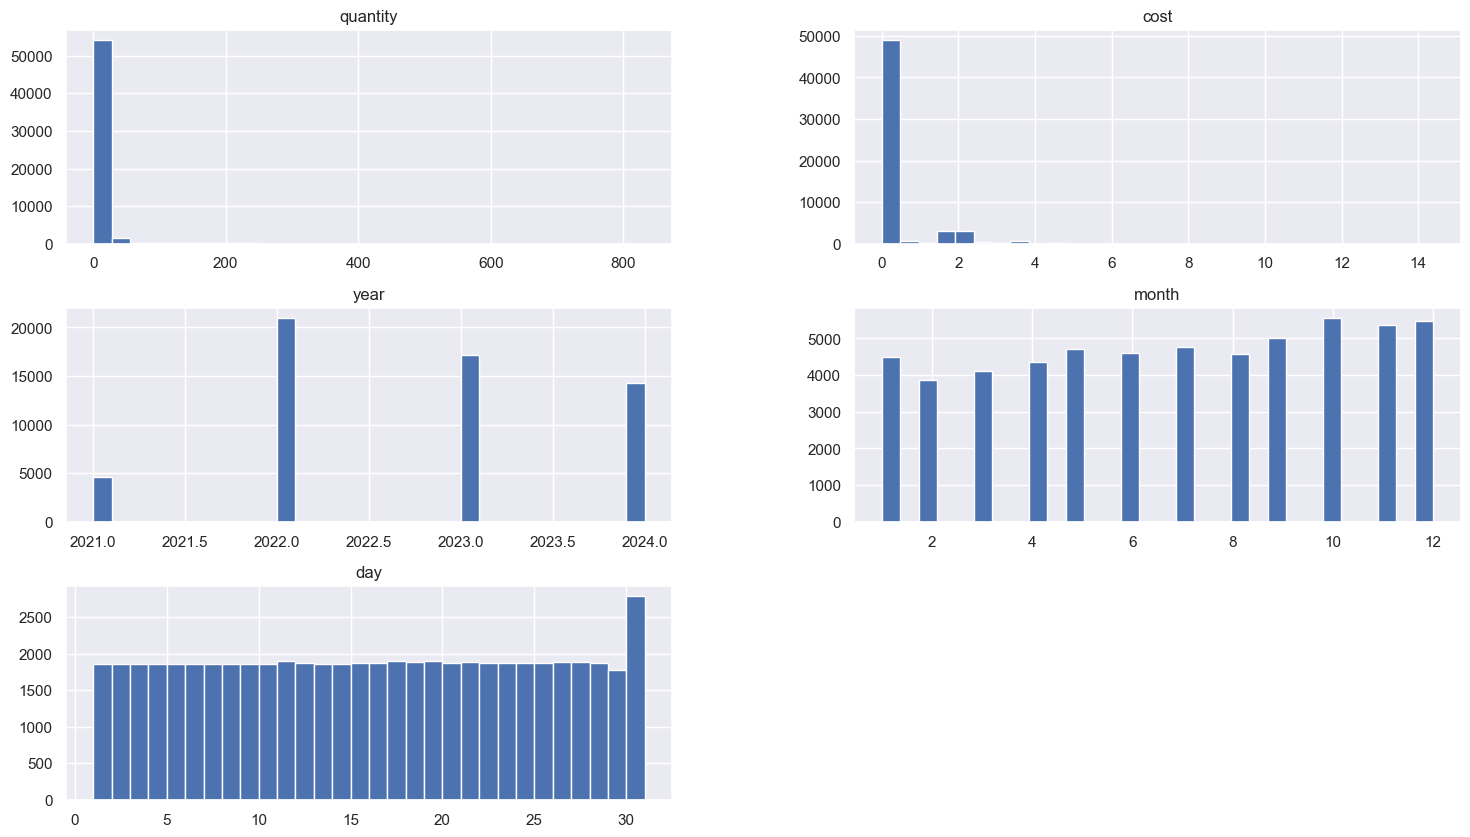

In [107]:
variaveis_numericas.hist(bins = 30);

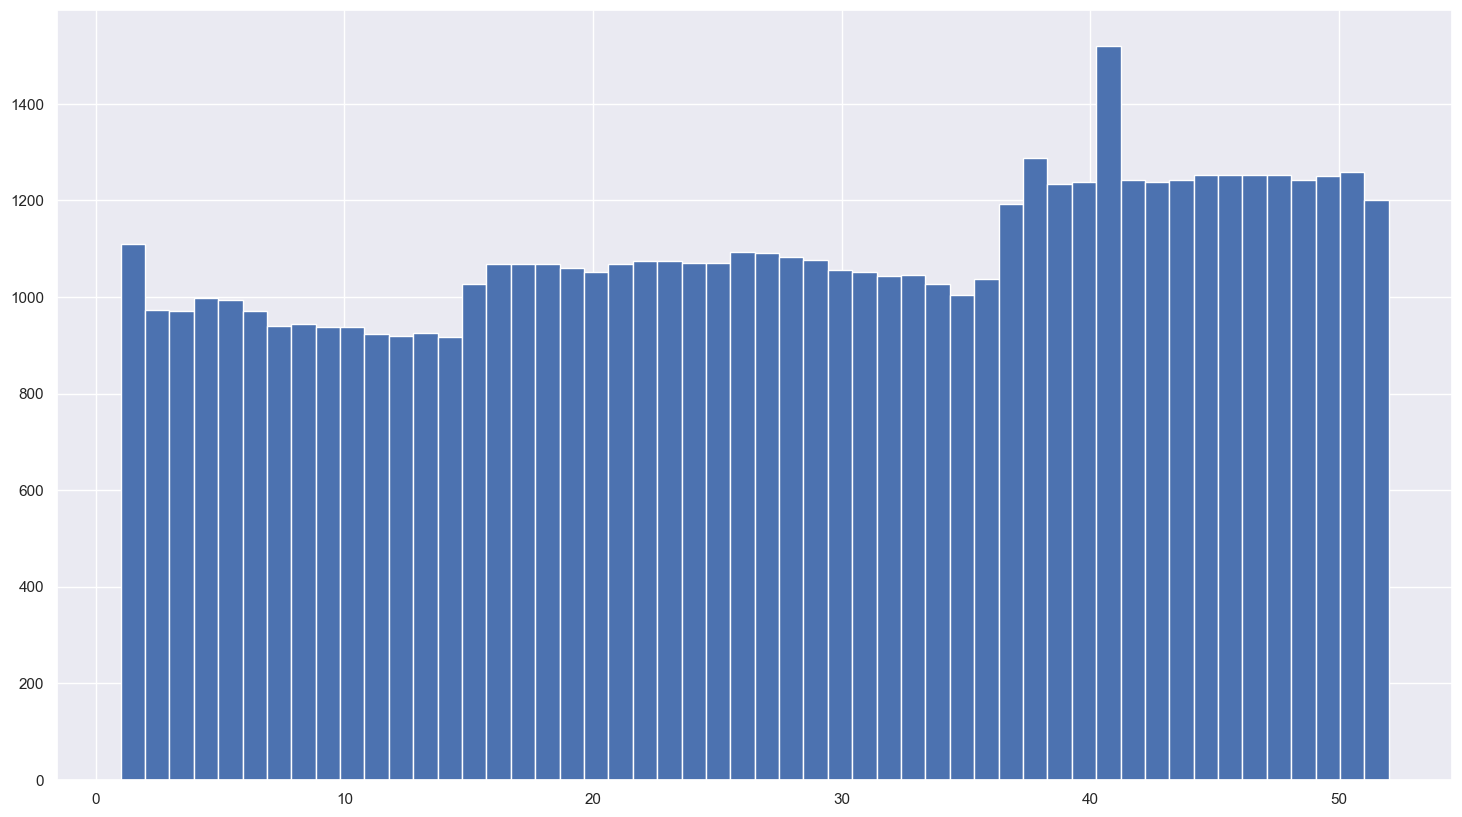

In [108]:
df['week_of_year'].hist(bins = 52);

### 1.5.2 Vairiáveis Categóricas

In [109]:
variaveis_categoricas.describe().T

,count,mean,std,min,25%,50%,75%,max
week_of_year,56933.000000,27.897037,15.068205,1.000000,15.000000,29.000000,41.000000,52.000000


In [110]:
visualizacao_dados_categoricos(variaveis_categoricas)

Atributo: subscription_name
Valores Únicos: 1
Valores Descritos: ['Microsoft Azure Sponsorship']

Atributo: subscription_guid
Valores Únicos: 3
Valores Descritos: ['0b1856f5-ffb1-4fb2-9b31-ebc3ddeacf68', '15dc64f3-696a-48fc-9169-8467e3f7bba0', '82375e17-0dda-4790-b6e8-c565d4f08e87']

Atributo: resource_guid
Valores Únicos: 86
Valores Descritos: ['05212985-faad-4b6c-8ddb-c08cc8e37f79', '0b248445-aa24-4fe8-a794-a174929327bd', '0b608a26-f611-4232-8192-ce81b6b57194', '0ddb5c81-143d-52f8-9ea3-29b64cc0ef97', '0f68ed30-d33d-4b1b-8533-f16ae059f71d', '0f824807-2376-435c-95c9-f992b67a07b0', '0fcb37f3-8a5a-4e81-820e-848908a57e44', '11ecb7d4-b18a-447a-bb0c-f057585fc701', '12da282f-7e96-49e2-983a-9a65da2a4866', '13c2d6a4-7f53-47a9-b6aa-8bb6167ac54d', '17b3fc96-9141-4e25-88f2-b8953f3ca784', '1adb9ebc-c08f-426d-9aa4-8af9de7b6d74', '1b74a37f-45a2-4266-bf07-2764801d0b85', '211e620c-ebcf-4db5-a7fd-996abebe9546', '26ce34b7-67b3-480d-9d1b-54a7fb80f67a', '27426e86-f015-4506-a8cc-26c18688990a', '28339581-90

# 1.6 Export PKL

In [111]:
exportar_df(df=df)